# Image Captioning with Visual Attention 

## Preparation

In [2]:
import time
from tqdm import tqdm
from textwrap import wrap
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    LSTM,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

print(tf.version.VERSION)

2.16.1


## Read and prepare dataset

Dữ liệu nghiên cứu được lấy từ kho Flickr 8k trên Kaggle. Flickr8k được sử dụng rộng rãi trong bài toán kết hợp giữa thị giác máy tính và xử lý ngôn ngữ tự nhiên như tạo chú thích hình ảnh. Đường dẫn để lấy dữ liệu [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k). <br>

Trong project này, chúng ta sẽ sử dụng mô hình đã được huấn luyện sẵn [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) từ `tf.keras.applications` như một bộ trích xuất đặc trưng.<br>

In [3]:
# Change these to control the accuracy/speed
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Filter and Preprocess
Tiền xử lý bộ dữ liệu bằng các kỹ thuật dưới đây::
- thay đổi kích thước hình ảnh về kích thước (`IMG_HEIGHT`, `IMG_WIDTH`)
- thay đổi giá trị pixel từ [0, 255] sang [0, 1]
- Trả về từ điển chứa hình ảnh(`image_tensor`) và chú thích (`captions`).

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from textwrap import wrap

BASE_DIR = "/kaggle/input/flickr8k"
CAPTION_FILE = os.path.join(BASE_DIR, "captions.txt")
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')

IMG_HEIGHT = 299
IMG_WIDTH = 299

def load_captions(caption_file):
    captions = []
    with open(caption_file, 'r') as f:
        next(f) # Bỏ qua dòng đầu tiên
        for line in f:
            # Tách tên ảnh và caption tại dấu phẩy
            image_filename, caption_text = line.strip().split(",", 1)
            # Cắt phần sau dấu chấm
            caption_text = caption_text.split(".")[0]  # Cắt phần sau dấu chấm
            captions.append((image_filename, caption_text))
    return captions

def get_image_label(image_filename, caption):
    img_path = os.path.join(IMAGE_DIR, image_filename)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255  # Chuẩn hóa ảnh
    return {"image_tensor": img, "caption": caption}


captions = load_captions(CAPTION_FILE)

In [5]:
BATCH_SIZE = 500  # Số lượng dữ liệu trong mỗi batch
batches = [captions[i:i + BATCH_SIZE] for i in range(0, len(captions), BATCH_SIZE)]

partial_datasets = []

for i, batch in enumerate(tqdm(batches, desc="Processing in batches")):
    image_data_list = []
    for image_filename, caption in batch:
        image_data = get_image_label(image_filename, caption)
        image_data_list.append(image_data)

    # Tạo tf.data.Dataset cho batch hiện tại
    batch_ds = tf.data.Dataset.from_generator(
        lambda: (data for data in image_data_list),
        output_signature={
            "image_tensor": tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            "caption": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    )

    partial_datasets.append(batch_ds)


Processing in batches: 100%|██████████| 81/81 [04:18<00:00,  3.19s/it]


In [6]:
# Hợp nhất tất cả datasets từ danh sách
trainds = tf.data.Dataset.from_tensor_slices(partial_datasets).flat_map(lambda x: x)

# Kiểm tra trainds
for data in trainds.take(1):
    print(data)

{'image_tensor': <tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.02726975, 0.03056774, 0.02792196],
        [0.03426509, 0.04210823, 0.03718987],
        [0.01277577, 0.02061891, 0.01570055],
        ...,
        [0.05499288, 0.05640914, 0.03974247],
        [0.06384405, 0.05992248, 0.05058416],
        [0.06976863, 0.06357437, 0.06138499]],

       [[0.0169716 , 0.02380962, 0.01254748],
        [0.02461985, 0.02947263, 0.0192031 ],
        [0.033846  , 0.03869878, 0.02842925],
        ...,
        [0.06860971, 0.07050356, 0.04380364],
        [0.07368437, 0.07125798, 0.04417424],
        [0.07468698, 0.0722606 , 0.04977812]],

       [[0.02943143, 0.03631353, 0.02502935],
        [0.02959073, 0.02959073, 0.02673152],
        [0.02166943, 0.02166943, 0.01881022],
        ...,
        [0.06628102, 0.06894994, 0.03507208],
        [0.07592171, 0.07592171, 0.03670602],
        [0.07296697, 0.07296697, 0.04159442]],

       ...,

       [[0.03649775, 0.04148181, 0.0311466

In [7]:
count = sum(1 for _ in trainds)
print(f"Số lượng dữ liệu trong trainds: {count}")

Số lượng dữ liệu trong trainds: 36855


In [66]:
# Tính tổng số phần tử
total_samples = sum(1 for _ in trainds)

# Xác định số lượng phần tử cho train và test
train_size = int(total_samples * 0.9)
test_size = total_samples - train_size

# Chia dataset thành train và test
train_dataset = trainds.take(train_size)
test_dataset = trainds.skip(train_size)

# Kiểm tra số lượng phần tử
print(f"Total samples: {total_samples}")
print(f"Train samples: {train_size}")
print(f"Test samples: {test_size}")

Total samples: 36855
Train samples: 33169
Test samples: 3686


### Visualize 
Xem các hình ảnh và ví dụ về chú thích trong bộ dữ liệu.

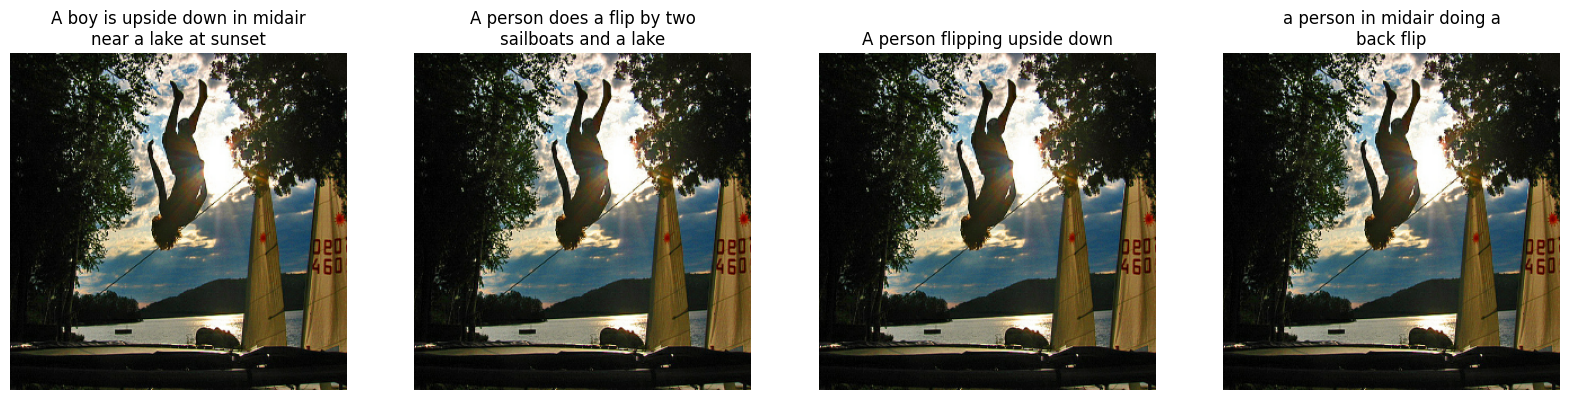

In [8]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Text Preprocessing

Thêm các token đặc biệt để đại diện cho bắt đầu (`<start>`) và kết thúc (`<end>`) của câu.<br>
Các token bắt đầu và kết thúc được thêm vào đây vì chúng ta đang sử dụng mô hình encoder-decoder, và trong quá trình dự đoán, để bắt đầu sinh chú thích, chúng ta sử dụng `<start>` và vì các chú thích có độ dài thay đổi, chúng ta kết thúc quá trình dự đoán khi gặp token `<end>`.

Sau đó, tạo một danh sách đầy đủ các chú thích để tiến hành tiền xử lý tiếp theo.

In [9]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


train_dataset = train_dataset.map(add_start_end_token)
count = sum(1 for _ in train_dataset)
print(f"Số lượng dữ liệu trong train_dataset: {count}")

Số lượng dữ liệu trong trainds: 36855


## Preprocess and tokenize the captions

Bạn sẽ chuyển đổi các chú thích văn bản thành các chuỗi số nguyên bằng cách sử dụng lớp [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), với các bước sau:

* Sử dụng [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) để lặp qua tất cả các chú thích, chia các chú thích thành các từ, và tính toán một từ vựng gồm các từ phổ biến nhất `VOCAB_SIZE`.
* Tokenize tất cả các chú thích bằng cách ánh xạ mỗi từ vào chỉ mục của nó trong từ vựng. Tất cả các chuỗi đầu ra sẽ được điền thêm (padding) đến độ dài `MAX_CAPTION_LEN`. Ở đây chúng ta chỉ định trực tiếp số `64` đủ cho bộ dữ liệu này, nhưng lưu ý rằng giá trị này nên được tính toán bằng cách xử lý toàn bộ bộ dữ liệu nếu bạn không muốn cắt giảm các câu rất dài trong bộ dữ liệu.

**Note**: Quá trình này mất khoảng 5 phút.

In [12]:
MAX_CAPTION_LEN = 64
VOCAB_SIZE = 20000

def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

In [13]:
# Save tokenizer trained
import json

# Lấy vocabulary từ tokenizer
vocab = tokenizer.get_vocabulary()

# Lưu vocabulary vào file JSON
with open('tokenizer_vocab.json', 'w') as f:
    json.dump(vocab, f)


In [14]:
# Load tokenizer trained
from tensorflow.keras.layers import TextVectorization

# Đọc vocabulary từ file JSON
with open('/kaggle/input/tokenizer_flickr8k/keras/default/1/tokenizer_vocab.json', 'r') as f:
    vocab = json.load(f)

# Tạo lại tokenizer từ vocabulary đã lưu
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)
tokenizer.set_vocabulary(vocab)

In [15]:
vocab = tokenizer.get_vocabulary()
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

817

Thử tokenizer trên một sample đơn giản

In [16]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 295,   8,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [17]:
sample_captions = []
for d in train_dataset.take(5):
    sample_captions.append(d["caption"].numpy())

In [18]:
sample_captions

[b'<start> A boy is upside down in midair near a lake at sunset  <end>',
 b'<start> A person does a flip by two sailboats and a lake  <end>',
 b'<start> A person flipping upside down <end>',
 b'<start> a person in midair doing a back flip  <end>',
 b'<start> A person is doing a flip in midair near a lake with sails behind him  <end>']

In [19]:
print(tokenizer(sample_captions))

tf.Tensor(
[[  3   2  16   8 293  39   6 241  49   2  88  30 466   4   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   2  41 387   2 259  61  14 532   9   2  88   4   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   2  41 688 293  39   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   2  41   6 241 263   2 218 259   4   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0 

Lưu ý rằng tất cả các câu bắt đầu và kết thúc bằng cùng một token (ví dụ: '3' và '4'). Các giá trị này đại diện cho token bắt đầu và token kết thúc tương ứng.

Bạn cũng có thể chuyển đổi các ID thành văn bản gốc.

In [20]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a boy is upside down in midair near a lake at sunset <end>                                                   

Ngoài ra, chúng ta có thể tạo các bộ chuyển đổi Word <-> Index bằng cách sử dụng lớp `StringLookup`.

In [21]:
# Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create a tf.data dataset for training
Áp dụng tokenization đã điều chỉnh cho tất cả các mẫu và tạo tf.data.Dataset cho quá trình huấn luyện.

Tạo nhãn (labels) bằng cách dịch chuyển văn bản từ các caption gốc.
Nếu một caption đầu vào là `"<start> I love cats <end>"`, nhãn của nó sẽ là `"I love cats <end> <padding>"`.<br>
Với cách này, mô hình sẽ học cách dự đoán từ `I` từ `<start>`.

Dưới đây là cách tạo dataset, trả về các bộ dữ liệu (tuples) trong đó phần tử đầu tiên là các tính năng (features) (`image_tensor` và `caption`) và phần tử thứ hai là nhãn (labels) (target).

In [22]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target

batched_ds = (
    train_dataset.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Xem một sample dữ liệu

In [23]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  16   8 293  39   6 241  49   2  88  30 466   4   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  16   8 293  39   6 241  49   2  88  30 466   4   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2 147   6 389 358 805  28 332   2 416  27   6   2 113   4   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

## Model
Thiết kế một mô hình Encoder-Decoder để sinh chú thích văn bản.<br>
Mô hình bao gồm một encoder ảnh, sau đó là một decoder chú thích.

### Image Encoder
Encoder ảnh rất đơn giản. Nó trích xuất các đặc trưng thông qua một mô hình đã được huấn luyện trước và truyền chúng qua một tầng fully connected.

1. Trích xuất các đặc trưng từ các tầng convolution của InceptionResNetV2, cho đầu ra một vector có kích thước (Batch Size, 8, 8, 1536).
1. Reshape vector thành kích thước (Batch Size, 64, 1536).
1. Sau đó nén nó thành độ dài `ATTENTION_DIM` bằng một tầng Dense và trả về kích thước (Batch Size, 64, ATTENTION_DIM).
1. Sau đó, tầng Attention sẽ tập trung vào ảnh để dự đoán từ tiếp theo.


In [24]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
print(image_input.shape)

image_features = FEATURE_EXTRACTOR(image_input)
print(image_features.shape)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

(None, 299, 299, 3)
(None, 8, 8, 1536)


In [25]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 8, 8, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1536)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 512)        │       786,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,123,680 (210.28 MB)

 Trainable params: 786,944 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

### Caption Decoder
Decoder sinh chú thích tích hợp cơ chế attention để tập trung vào các phần khác nhau của ảnh đầu vào.

#### The attention head

Decoder sử dụng cơ chế attention để tập trung chọn lọc vào các phần của dãy đầu vào. Cơ chế attention nhận một dãy các vector làm đầu vào cho mỗi ví dụ và trả về một vector "attention" cho mỗi ví dụ.

Cơ chế hoạt động:

<img src="https://user-images.githubusercontent.com/6895245/173408554-d4b6387b-248b-421e-8911-550d0561d001.png" alt="attention equation 1" width="800">

<img src="https://user-images.githubusercontent.com/6895245/173408648-38c6b582-a68b-4697-982a-1d885b83dd0b.png" alt="attention equation 2" width="800">

Trong đó:

* $s$ là chỉ số của encoder.
* $t$ là chỉ số của decoder.
* $\alpha_{ts}$ là trọng số attention.
* $h_s$ là dãy các đầu ra của encoder được chú ý đến (là "key" và "value" trong thuật ngữ của transformer).
* $h_t$ là trạng thái của decoder đang chú ý đến dãy này (là "query" trong thuật ngữ của transformer).
* $c_t$ là vector bối cảnh (context vector) kết quả.

Các phương trình:

1. Tính toán trọng số attention, $\alpha_{ts}$, thông qua softmax trên dãy đầu ra của encoder.
2. Tính toán vector bối cảnh như là tổng có trọng số của các đầu ra từ encoder.

Cuối cùng là hàm $score$. Nhiệm vụ của nó là tính toán một scalar logit-score cho mỗi cặp key-query. Có hai phương pháp phổ biến:

<img src="https://user-images.githubusercontent.com/6895245/173408773-3781cacc-de00-49c6-9909-f6cd65a0501b.png" alt="attention equation 4" width="800">

Notebook này triển khai attention theo `layers.Attention` đã được định nghĩa sẵn.

#### Decoder Steps

Nhiệm vụ của decoder là tạo ra dự đoán cho token đầu ra tiếp theo.

1. Decoder nhận các token từ đầu vào hiện tại dưới dạng batch.
1. Chuyển các token từ đầu vào thành vector embedding với kích thước `ATTENTION_DIM`.
1. Lớp LSTM theo dõi các embedding này và trả về đầu ra LSTM cùng các trạng thái.
1. Attention kiểu Bahdanau thực hiện attention trên đặc trưng đầu ra của encoder bằng cách sử dụng đầu ra LSTM làm query.
1. Đầu ra từ attention và LSTM được cộng lại (skip connection) và được chuẩn hóa trong một lớp layer normalization.
1. Tạo ra các logit dự đoán cho token tiếp theo dựa trên đầu ra của LSTM.

Chúng ta có thể định nghĩa tất cả các bước này bằng Keras Functional API, nhưng lưu ý rằng ở đây chúng ta khởi tạo các layer có tham số huấn luyện được để tái sử dụng các layer và trọng số trong giai đoạn suy luận.

In [26]:
word_input = Input(shape=(MAX_CAPTION_LEN,), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM, mask_zero=False)(word_input)

from tensorflow.keras.layers import LSTM

decoder_lstm = LSTM(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)

# Lấy các giá trị đầu ra từ LSTM
lstm_output, lstm_hidden_state, lstm_cell_state = decoder_lstm(embed_x)

# Sử dụng lstm_output thay vì lstm_output trong Attention
decoder_attention = Attention()
context_vector = decoder_attention([lstm_output, encoder_output])

# Thực hiện cộng thêm context_vector vào lstm_output
addition = Add()([lstm_output, context_vector])

# Áp dụng LayerNormalization
layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

# Tạo đầu ra từ dense layer
decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

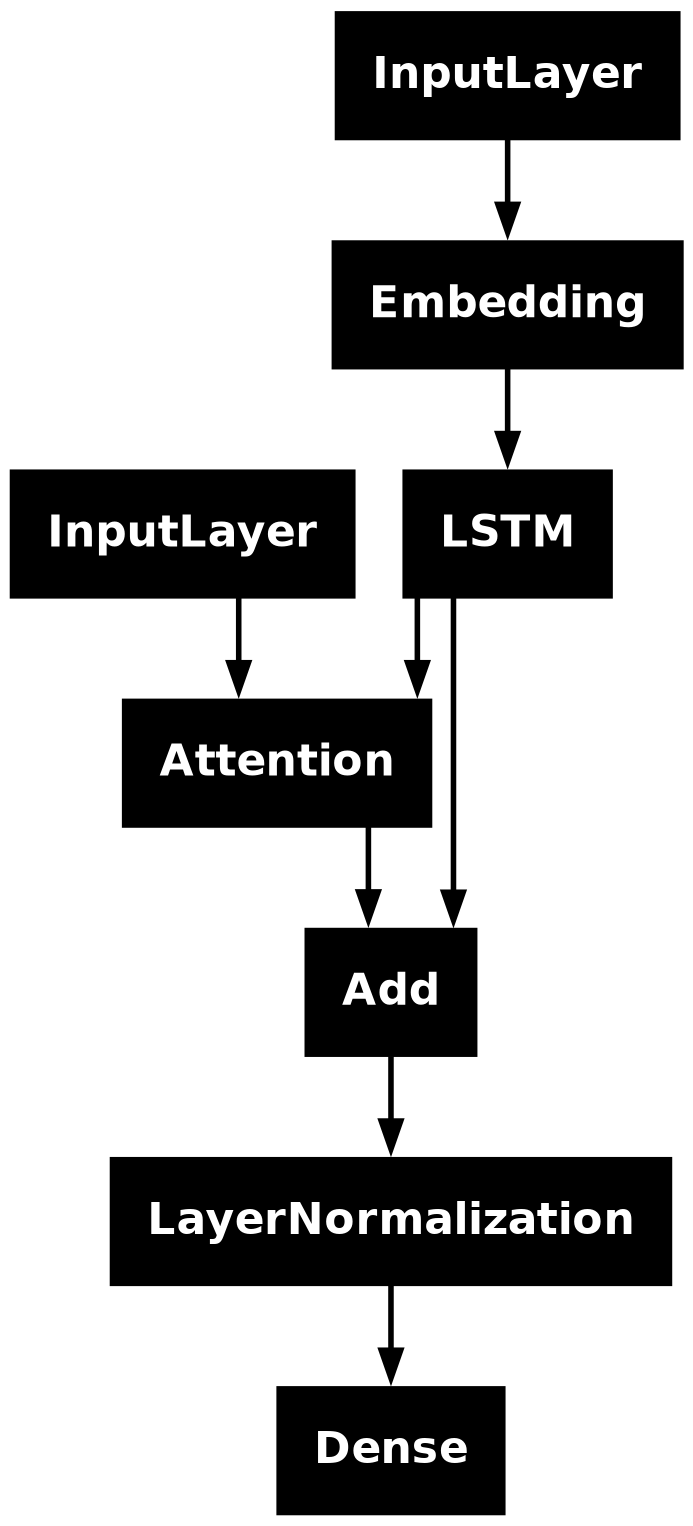

In [27]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [28]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ words (InputLayer)  │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 512)   │    418,304 │ words[2][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64, 512), │  2,099,200 │ embedding[2][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_3217C… │ (None, 64, 512)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 64, 512)   │          0 │ lstm[2][0],       │
│ (Attention)         │                   │            │ keras_tensor_321… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 512)   │          0 │ lstm[2][0],       │
│                     │                   │            │ attention[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 512)   │      1,024 │ add[2][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 817)   │    419,121 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,937,649 (11.21 MB)

 Trainable params: 2,937,649 (11.21 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model
Encoder và decoder đã được định nghĩa. Kết hợp thành một mô hình tổng hợp để huấn luyện.
Mô hình này có hai đầu vào (`image_input` và `word_input`) và một đầu ra (`decoder_output`).
Định nghĩa này cần tương ứng với định nghĩa của pipeline dữ liệu.

In [29]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

### Loss Function
Hàm mất mát là cross-entropy đơn giản, nhưng cần loại bỏ phần padding (giá trị 0) khi tính toán.<br>
Do đó, trong bước này, trích xuất độ dài của câu (phần không chứa giá trị 0) và tính trung bình hàm mất mát chỉ trên phần câu hợp lệ.

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [31]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

## Training loop

Train model với `model.fit` API.<br>
Quá trình mất khoảng 5-15 phút với Kaggle GPU T4 x 2 trên mỗi 1 epoch.

In [33]:
# Tạo đối tượng CSVLogger để lưu loss sau mỗi epoch vào file CSV
csv_logger = CSVLogger('training_loss.csv', append=True)

# Tạo đối tượng ModelCheckpoint để lưu mô hình mỗi 3 epoch
model_checkpoint = ModelCheckpoint(
    'model_ep_{epoch}.keras',  # Lưu mô hình với tên theo epoch, thay đổi phần mở rộng thành .keras
    save_freq='epoch',           # Lưu mô hình mỗi epoch
    save_best_only=False,        # Lưu tất cả mô hình, không chỉ mô hình tốt nhất
    save_weights_only=False      # Lưu toàn bộ mô hình, không chỉ trọng số
)

# Huấn luyện mô hình trong 20 epoch
history = image_caption_train_model.fit(
    batched_ds,
    epochs=20,
    callbacks=[csv_logger, model_checkpoint]  # Dùng cả CSVLogger và ModelCheckpoint
)

# In ra kết quả huấn luyện
print("Training Complete")

Epoch 1/20
   1151/Unknown 500s 416ms/step - loss: 0.6368

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1151/1151 ━━━━━━━━━━━━━━━━━━━━ 502s 417ms/step - loss: 0.6365
Epoch 2/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0331
Epoch 3/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 418ms/step - loss: 0.0296
Epoch 4/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0274
Epoch 5/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0298
Epoch 6/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0265
Epoch 7/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0263
Epoch 8/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0280
Epoch 9/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0259
Epoch 10/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0263
Epoch 11/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 417ms/step - loss: 0.0258
Epoch 12/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 481s 418ms/step - loss: 0.0257
Epoch 13/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 418ms/step - loss: 0.0256
Epoch 14/20
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 482s 419ms/step

## Caption!

Bước dự đoán khác với quá trình huấn luyện, bởi vì chúng ta cần theo dõi trạng thái của LSTM trong quá trình sinh chú thích (caption) và truyền từ được dự đoán vào decoder làm đầu vào tại bước thời gian tiếp theo.

Để thực hiện điều này, chúng ta sẽ định nghĩa một mô hình khác dành cho việc dự đoán, sử dụng các trọng số đã được huấn luyện, để có thể lưu trữ và cập nhật trạng thái của LSTM trong suốt quá trình sinh chú thích.

In [37]:
lstm_hidden_state_input = Input(shape=(ATTENTION_DIM,), name="lstm_hidden_state_input")  # Hidden state
lstm_cell_state_input = Input(shape=(ATTENTION_DIM,), name="lstm_cell_state_input")  # Cell state

# Reuse trained LSTM, but update it so that it can receive states.
lstm_output, lstm_hidden_state, lstm_cell_state = decoder_lstm(embed_x, initial_state=[lstm_hidden_state_input, lstm_cell_state_input])

# Reuse other layers as well
context_vector = decoder_attention([lstm_output, encoder_output])
addition_output = Add()([lstm_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, lstm_hidden_state_input, lstm_cell_state_input, encoder_output],
    outputs=[decoder_output, lstm_hidden_state, lstm_cell_state]
)

In [38]:
# Lưu mô hình dưới dạng .keras
decoder_pred_model.save("decoder_pred_model.keras")

# Tải lại mô hình từ file .keras
loaded_model = tf.keras.models.load_model("decoder_pred_model.keras")

# Kiểm tra mô hình đã tải
print(loaded_model.summary())


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ words (InputLayer)  │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 512)   │    418,304 │ words[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_hidden_state_… │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_cell_state_in… │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64, 512), │  2,099,200 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ lstm_hidden_stat… │
│                     │ (None, 512)]      │            │ lstm_cell_state_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_3217C… │ (None, 64, 512)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 64, 512)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ keras_tensor_321… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 512)   │          0 │ lstm[0][0],       │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 817)   │    419,121 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,937,649 (11.21 MB)

 Trainable params: 2,937,649 (11.21 MB)

 Non-trainable params: 0 (0.00 B)

None




1. Khởi tạo các trạng thái LSTM là các vector không.
1. Tiền xử lý một ảnh đầu vào, truyền ảnh qua encoder và trích xuất đặc trưng ảnh.
1. Thiết lập token từ `<start>` để bắt đầu quá trình sinh chú thích.
1. Trong vòng lặp for, thực hiện:
    - Truyền các token từ (`dec_input`), trạng thái LSTM (`lstm_hidden_state`, `lstm_cell_state`) và đặc trưng ảnh (`features`) vào decoder dự đoán để nhận các dự đoán (`predictions`) và các trạng thái LSTM được cập nhật.
    - Chọn Top-K từ từ logits và chọn một từ theo xác suất để tránh tính softmax trên vector có kích thước VOCAB_SIZE.
    - Dừng dự đoán khi mô hình dự đoán token `<end>`.
    - Thay thế token đầu vào bằng token được dự đoán cho bước tiếp theo.

In [47]:
def predict_caption(filename):
    # Khởi tạo trạng thái LSTM (hidden state và cell state)
    lstm_hidden_state = tf.zeros((1, ATTENTION_DIM))
    lstm_cell_state = tf.zeros((1, ATTENTION_DIM))

    # Đọc và tiền xử lý ảnh
    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    # Trích xuất đặc trưng ảnh từ encoder
    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []

    for i in range(MAX_CAPTION_LEN):
        # Dự đoán từ tiếp theo và cập nhật trạng thái LSTM
        predictions, lstm_hidden_state, lstm_cell_state = loaded_model(
            [dec_input, lstm_hidden_state, lstm_cell_state, features]
        )

        # Lấy top k dự đoán và chọn ngẫu nhiên 1 từ trong top k
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=5, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        # Thêm từ được dự đoán vào kết quả
        result.append(tokenizer.get_vocabulary()[predicted_id])

        # Dừng nếu gặp từ <end>
        if predicted_id == word_to_index("<end>"):
            return img, result

        # Chuẩn bị đầu vào cho từ tiếp theo
        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

Tạo caption cho hình ảnh

a man and a dog on a dock are watching another dog swim away <end>.
a man with a brwon jacket on his shoulders lying on the sidewalk near two atm machines <end>.
a man with a brwon jacket on his shoulders lying on the sidewalk near two atm machines <end>.
a man and a dog on a dock are watching another dog swim away <end>.
a dog leaps out of the water <end>.


(-0.5, 499.5, 374.5, -0.5)

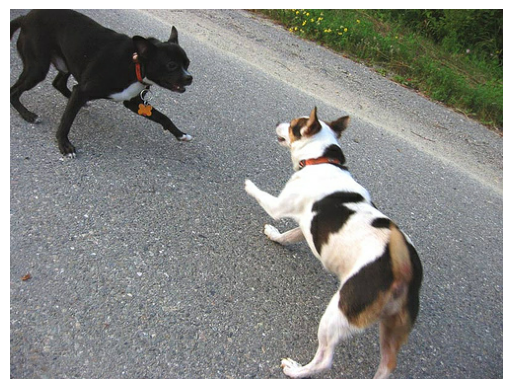

In [48]:
# Test mô hình
filename = "/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption) + ".")  # Dừng khi gặp token <end>

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off")

a five girl in a white is running through a grassy area <end>.
a five girl in a white and a brown dog and a black dog looking at another dog in orange picture of a climbing up picture of a climbs dog rays of water <end>.
a five girl in a white is running through a grassy area <end>.
a a person is orange in the sun is blazing through the trees onto a green in the orange climbing the tree <end>.
picture of a ice <end>.


(-0.5, 499.5, 356.5, -0.5)

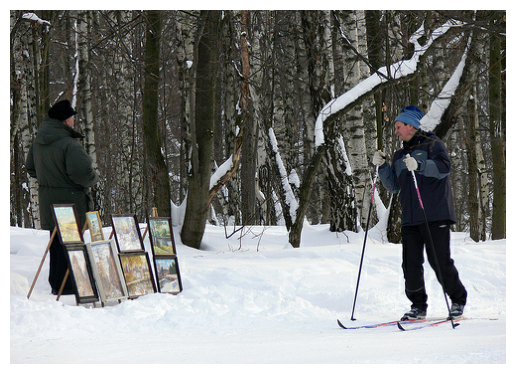

In [49]:
# Test mô hình
filename = "/kaggle/input/flickr8k/Images/101669240_b2d3e7f17b.jpg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption) + ".")  # Dừng khi gặp token <end>

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off")

## Evaluate

In [53]:
def predict_caption_evaluate(img):
    # Khởi tạo trạng thái LSTM (hidden state và cell state)
    lstm_hidden_state = tf.zeros((1, ATTENTION_DIM))
    lstm_cell_state = tf.zeros((1, ATTENTION_DIM))

    # Trích xuất đặc trưng ảnh từ encoder
    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []

    for i in range(MAX_CAPTION_LEN):
        # Dự đoán từ tiếp theo và cập nhật trạng thái LSTM
        predictions, lstm_hidden_state, lstm_cell_state = loaded_model(
            [dec_input, lstm_hidden_state, lstm_cell_state, features]
        )

        # Lấy top k dự đoán và chọn ngẫu nhiên 1 từ trong top k
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=5, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        # Thêm từ được dự đoán vào kết quả
        result.append(tokenizer.get_vocabulary()[predicted_id])

        # Dừng nếu gặp từ <end>
        if predicted_id == word_to_index("<end>"):
            return img, result

        # Chuẩn bị đầu vào cho từ tiếp theo
        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

In [60]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for data in tqdm(test_dataset):
    caption = data["caption"].numpy().decode('utf-8')
    image, predict = predict_caption_evaluate(data["image_tensor"])
    actual.append(caption)
    predicted.append(predict)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

3686it [48:52,  1.26it/s]
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.072786
BLEU-2: 0.269788


In [61]:
# Tạo dictionary để lưu
output_data = {
    "actual": actual,
    "predicted": predicted
}

# Lưu vào tệp JSON
with open("captions.json", "w", encoding="utf-8") as json_file:
    json.dump(output_data, json_file, ensure_ascii=False, indent=4)

print("Dữ liệu đã được lưu vào file captions.json")

Dữ liệu đã được lưu vào file captions.json


In [65]:
from nltk.translate.bleu_score import corpus_bleu

# Tính điểm BLEU
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.072786
BLEU-2: 0.269788
BLEU-3: 0.421187
BLEU-4: 0.519411


## Reference
[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)